# Обучение MeshVAE!
## Импорт библиотек

In [1]:
import torch
import torch.nn as nn

import os

import pandas as pd
import matplotlib.pyplot as plt

import torchvision.transforms as transforms


from torch.utils.checkpoint import checkpoint_sequential
from torchvision.transforms import Resize
from pathlib import Path
from tqdm import tqdm

from pytorch3d.renderer import look_at_view_transform
from pytorch3d.renderer import (
FoVPerspectiveCameras, VolumeRenderer,
NDCGridRaysampler, EmissionAbsorptionRaymarcher
)

from modelnet import ModelNetRendersNoLabels
from Houses import Houses3KRendersNoLabels

from sklearn.model_selection import train_test_split


from model_collection.MeshVAE import MeshVAE
from model_collection.utils import huber_loss, max_VRAM_optim_fit
from model_collection.VAE_loss.VaeLoss import VAELossGAN
from model_collection.VAE_loss.vgg19 import VGG19

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
torch.cuda.empty_cache()

## Определение девайса, датасета и даталоадера

In [3]:
USE_CUDA = True
device = 'cuda' if torch.cuda.is_available() and USE_CUDA else 'cpu'
print('Using', device)

# data_sheet = pd.read_csv('./modelnet_renders_metadata.csv')
# data_train = data_sheet[data_sheet['split'] == ' train']
# data_test = data_sheet[data_sheet['split'] == ' test']
work_root = os.getcwd()
dataset_root = Path(work_root) / 'houses_dataset' / 'Houses3K_dataset'
data_sheet = pd.read_csv(dataset_root / 'metadata.csv')
data_train, data_test = train_test_split(data_sheet, test_size=0.2, random_state=42)

image_size = 64
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.Normalize(0.5, 0.5)])

dataset_train = Houses3KRendersNoLabels(dataset_root_dir=dataset_root,data_sheet=data_train, transform=transform, device=device)
dataset_test = Houses3KRendersNoLabels(dataset_root_dir=dataset_root,data_sheet=data_test, transform=transform, device=device)

print(f"Test set has {len(data_test['class'].unique())} classes\nTrain set has {len(data_train['class'].unique())} classes")

data_overfit = pd.DataFrame([data_train.iloc[0], data_train.iloc[0]]) # , data_test.iloc[450]
dataset_overfit = ModelNetRendersNoLabels(dataset_root_dir=dataset_root,data_sheet=data_overfit, transform=None, device=device)
overfit_dl = torch.utils.data.DataLoader(dataset = dataset_overfit,
                                                      batch_size = 2,
                                                      num_workers = 0,
                                                      shuffle = True)

BATCH_SIZE = 6

train_dl = torch.utils.data.DataLoader(dataset = dataset_train,
                                                      batch_size = BATCH_SIZE,
                                                      num_workers = 0,
                                                      shuffle = True)

test_dl = torch.utils.data.DataLoader(dataset = dataset_test,
                                                      batch_size = BATCH_SIZE,
                                                      num_workers = 0,
                                                      shuffle = False)

Using cuda
Test set has 23 classes
Train set has 23 classes


## Определение модели, оптимизатора и метода learning rate annealing

In [4]:
# classifier
class ResDown(nn.Module):
    def __init__(self, channel_in, channel_out, kernel_size=3):
        super(ResDown, self).__init__()
        self.conv1 = nn.Conv3d(channel_in, channel_out // 2, kernel_size, 2, kernel_size // 2)
        self.bn1 = nn.BatchNorm3d(channel_out // 2, eps=1e-4)
        self.conv2 = nn.Conv3d(channel_out // 2, channel_out, kernel_size, 1, kernel_size // 2)
        self.bn2 = nn.BatchNorm3d(channel_out, eps=1e-4)

        self.conv3 = nn.Conv3d(channel_in, channel_out, kernel_size, 2, kernel_size // 2)

        self.act_fnc = nn.ELU()

    def forward(self, x):
        skip = self.conv3(x)
        x = self.act_fnc(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return self.act_fnc(self.bn2(x + skip))


class Descriptor(nn.Module):
    def __init__(self, channels, hidden_channels=64):
        super(Descriptor, self).__init__()
        self.conv_in = nn.Conv3d(channels, hidden_channels, 7, 1, 3)
        self.res_down_block1 = ResDown(hidden_channels, 2 * hidden_channels)
        self.res_down_block2 = ResDown(2 * hidden_channels, 4 * hidden_channels)
        self.res_down_block3 = ResDown(4 * hidden_channels, 8 * hidden_channels)
        self.res_down_block4 = ResDown(8 * hidden_channels, 16 * hidden_channels)
        
        self.act_fnc = nn.ELU()
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(49152, 1),
            # nn.Linear(163840, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.act_fnc(self.conv_in(x))
        x = self.res_down_block1(x)  # 32
        x = self.res_down_block2(x)  # 16
        x = self.res_down_block3(x)  # 8
        x = self.res_down_block4(x)  # 4
        return self.classify(x)

    def feature_loss(self, x):
        return (x[:x.shape[0] // 2] - x[x.shape[0] // 2:]).pow(2).mean()

    def perc_loss(self, x):
        x = self.act_fnc(self.conv_in(x))
        loss = self.feature_loss(x)
        x = self.res_down_block1(x)  # 32
        loss += self.feature_loss(x)
        x = self.res_down_block2(x)  # 16
        loss += self.feature_loss(x)
        x = self.res_down_block3(x)  # 8
        loss += self.feature_loss(x)
        x = self.res_down_block4(x)  # 4
        loss += self.feature_loss(x)
        return loss / 5

In [5]:
wpath = Path('./models') / 'VGG19'
# descriptor_sil = VGG19(num_classes=1, load_weights=True, weights_path=wpath / '21' / 'best.pt').to(device)
descriptor_col = VGG19(num_classes=1, load_weights=True, weights_path=wpath / '22' / 'best.pt').to(device)

descriptor_sil = Descriptor(channels=3).to(device)
# descriptor_col = Descriptor(channels=3).to(device)

# descriptor_sil.load_state_dict(torch.load(Path('./models') / 'descriptor_sil' / 'best.pt'))
# descriptor_col.load_state_dict(torch.load(Path('./models') / 'descriptor_col' / 'best.pt'))


sil_optimizer = torch.optim.Adam(descriptor_sil.parameters(), lr=1e-5)
col_optimizer = torch.optim.Adam(descriptor_col.parameters(), lr=1e-5)


model = MeshVAE().to(device)
model.load_state_dict(torch.load(Path('./models') / 'MeshVAE' / '41' / 'last.pt'))
criterion = VAELossGAN(device=device, clamp=True, clamp_threshold=10000., 
                       adv_net_sil=descriptor_sil, adv_net_sil_optim=sil_optimizer, 
                       adv_net_col=descriptor_col, adv_net_col_optim=col_optimizer,
                       KLD_coef = 1.,)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, betas=(0.5, 0.999))
scheduler = None # torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=60, T_mult=2)

## Обучение!

In [6]:
epochs = 100
torch.cuda.empty_cache()
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
torch.autograd.set_detect_anomaly(True)
max_VRAM_optim_fit(train_launch=41,
                   model=model, optimizer=optimizer, criterion=criterion,
                   train_dl=train_dl, test_dl=test_dl, 
                   device=device, epochs=epochs,
                   scheduler=scheduler,
                   weights_save_dir=Path('./models'),
                   early_stopping=False, early_stopping_tolerance = 5,
                   restore_best_weights=False, save_loss_history=True, overfit_mode=False, mode='gan')

==========Epoch 1==========
Training...


/home/student/miniforge3/envs/pytorch3d/lib/python3.9/site-packages/torch/utils/checkpoint.py:553: UserWarning: torch.utils.checkpoint.checkpoint_sequential: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/student/miniforge3/envs/pytorch3d/lib/python3.9/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/student/miniforge3/envs/pytorch3d/lib/python3.9/site-packages/pytorch3d/renderer/implicit/raymarching.py:188: UserWarning: One or more elements of rays_densities are outside of validrange (0.0, 1.0)
  warnings.warn(
100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.38 | Test loss: 1.38
Saved weights to models/MeshVAE/41/best.pt
==========Epoch 2==========
Training...


100%|██████████| 146/146 [07:06<00:00,  2.92s/it]


Train loss: 1.42 | Test loss: 1.42
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 3==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.92s/it]


Train loss: 1.47 | Test loss: 1.47
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 4==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.50 | Test loss: 1.50
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 5==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.52 | Test loss: 1.52
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 6==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.53 | Test loss: 1.53
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 7==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.54 | Test loss: 1.54
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 8==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.55 | Test loss: 1.55
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 9==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.56 | Test loss: 1.56
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 10==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.57 | Test loss: 1.57
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 11==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.58 | Test loss: 1.58
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 12==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.58 | Test loss: 1.58
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 13==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 14==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.58 | Test loss: 1.58
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 15==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.59 | Test loss: 1.59
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 16==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.59 | Test loss: 1.59
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 17==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.58 | Test loss: 1.58
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 18==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.59 | Test loss: 1.59
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 19==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.58 | Test loss: 1.58
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 20==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.59 | Test loss: 1.59
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 21==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.58 | Test loss: 1.58
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 22==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 23==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.59 | Test loss: 1.59
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 24==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 25==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 26==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 27==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.90s/it]


Train loss: 1.59 | Test loss: 1.59
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 28==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.59 | Test loss: 1.59
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 29==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.59 | Test loss: 1.59
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 30==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 31==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.59 | Test loss: 1.59
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 32==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 33==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 34==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 35==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 36==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 37==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 38==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 39==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 40==========
Training...


100%|██████████| 146/146 [09:15<00:00,  3.80s/it]


Train loss: 1.59 | Test loss: 1.59
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 41==========
Training...


100%|██████████| 146/146 [07:28<00:00,  3.08s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 42==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 43==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.59 | Test loss: 1.59
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 44==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 45==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 46==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 47==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 48==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 49==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 50==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 51==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 52==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 53==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 54==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 55==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 56==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 57==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 58==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 59==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 60==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 61==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 62==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 63==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 64==========
Training...


100%|██████████| 146/146 [07:47<00:00,  3.20s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 65==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 66==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 67==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 68==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 69==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 70==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 71==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 72==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 73==========
Training...


100%|██████████| 146/146 [07:15<00:00,  2.99s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 74==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 75==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 76==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 77==========
Training...


100%|██████████| 146/146 [07:08<00:00,  2.93s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 78==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.92s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 79==========
Training...


100%|██████████| 146/146 [07:06<00:00,  2.92s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 80==========
Training...


100%|██████████| 146/146 [07:06<00:00,  2.92s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 81==========
Training...


100%|██████████| 146/146 [07:06<00:00,  2.92s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 82==========
Training...


100%|██████████| 146/146 [07:05<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 83==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 84==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 85==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 86==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 87==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.91s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 88==========
Training...


100%|██████████| 146/146 [07:04<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 89==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 90==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 91==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 92==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.62 | Test loss: 1.62
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 93==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 94==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 95==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.62 | Test loss: 1.62
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 96==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 97==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 98==========
Training...


100%|██████████| 146/146 [07:03<00:00,  2.90s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 99==========
Training...


100%|██████████| 146/146 [07:07<00:00,  2.93s/it]


Train loss: 1.61 | Test loss: 1.61
Saved weights to models/MeshVAE/41/last.pt
==========Epoch 100==========
Training...


100%|██████████| 146/146 [07:11<00:00,  2.95s/it]


Train loss: 1.60 | Test loss: 1.60
Saved weights to models/MeshVAE/41/last.pt


In [ ]:
(Path('./models') / 'descriptor_sil' / '35').mkdir(exist_ok=True)
(Path('./models') / 'descriptor_col' / '35').mkdir(exist_ok=True)
torch.save(descriptor_sil.state_dict(), Path('./models') / 'descriptor_sil' / '37' / 'best.pt')
torch.save(descriptor_col.state_dict(), Path('./models') / 'descriptor_col' / '37' / 'best.pt')

## Инференс!!

In [6]:
# model = MeshVAE().to(device)
model.load_state_dict(torch.load(Path('./models') / 'MeshVAE' / '35' / 'last.pt'))
model.eval()

MeshVAE(
  (encoder): Encoder(
    (conv_in): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 1, 1), padding=(3, 3, 3))
    (res_down_block1): ResDown(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (bn1): BatchNorm3d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (act_fnc): ELU(alpha=1.0)
    )
    (res_down_block2): ResDown(
      (conv1): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (bn1): BatchNorm3d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (bn2): BatchNorm3d(256, eps=0.00

In [6]:
from time import time

In [7]:
def get_model(dataset, dataset_model_number):
    get_renders = torch.stack((dataset[dataset_model_number], dataset[dataset_model_number]), 0)
    # get_renders = dataset[dataset_model_number].unsqueeze(0)
    print(get_renders.shape)

    ren_imgs, rend_sils = None, None
    target_imgs, target_sils = None, None
    with torch.inference_mode():
        # get model
        input_renders = get_renders
        target_renders, target_silhouttes = input_renders.to(device).split([1, 1], dim = 1)
        # target_renders, target_silhouttes = target_renders.squeeze().unsqueeze(2), target_silhouttes.squeeze().unsqueeze(2)
        target_renders, target_silhouttes = target_renders.squeeze(), target_silhouttes.squeeze()
        target_imgs, target_sils = target_renders.cpu(), target_silhouttes.cpu()
        # print(target_renders.shape)
        time_gen = time()
        mu, logvar, output_model = model(target_renders)
        # print('generated within', time()-time_gen)
        num_views, azimuth_range = 40, 180.0
        elev = torch.linspace(0, 0, num_views // 2)  # keep constant
        azim = torch.linspace(azimuth_range, -azimuth_range, num_views // 2) + 180.0
        R1, T1 = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
        
        elev = torch.linspace(20, 20, num_views // 2)  # keep constant
        azim = torch.linspace(azimuth_range, -azimuth_range, num_views // 2) + 180.0
        R2, T2 = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
        
        R, T = torch.cat((R1,R2), 0), torch.cat((T1,T2), 0)
        
        target_cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
        target_cameras = target_cameras.to(device)
    
        rendered_images_silhouettes = model.get_renders(output_model, target_cameras)
        rendered_images, rendered_silhouttes = rendered_images_silhouettes.split([3, 1], dim = -1)
        ren_imgs, rend_sils = rendered_images.permute(0, 4, 1, 2, 3), rendered_silhouttes.permute(0, 4, 1, 2, 3)
    
        del input_renders
        del rendered_images_silhouettes
        del rendered_images
        del rendered_silhouttes
        del target_cameras
        torch.cuda.empty_cache()
    
    ren_imgs, rend_sils = ren_imgs.squeeze().detach().cpu()[0], rend_sils.squeeze().detach().cpu()[0]
    return ren_imgs, rend_sils, target_imgs, target_sils, mu.detach().cpu()

In [9]:
%%time
dataset_model_number = 483
datasets = [dataset_train, dataset_test]
dataset = datasets[0]

ren_imgs, rend_sils, target_imgs, target_sils, mu = get_model(dataset=dataset, dataset_model_number=dataset_model_number)

torch.Size([2, 2, 3, 40, 64, 64])
CPU times: user 1.46 s, sys: 63.1 ms, total: 1.52 s
Wall time: 191 ms


In [10]:
dataset = datasets[0]
prev_latent = None
mu_mean = torch.zeros(3990, 512)
cum_diff = torch.zeros(512).float()
for i in tqdm(range(len(dataset))):
    _, _, _, _, mu = get_model(dataset=dataset, dataset_model_number=i)
    latent = mu[0].squeeze()
    if prev_latent is None:
        prev_latent = latent
    else:
        cum_diff += (latent - prev_latent).abs()
        prev_latent = latent
    mu_mean[i] = latent

  0%|          | 0/872 [00:00<?, ?it/s]

torch.Size([2, 2, 3, 40, 64, 64])


  0%|          | 1/872 [00:00<03:06,  4.67it/s]

torch.Size([2, 2, 3, 40, 64, 64])


  0%|          | 2/872 [00:00<03:14,  4.47it/s]

torch.Size([2, 2, 3, 40, 64, 64])


  0%|          | 4/872 [00:00<02:57,  4.88it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  1%|          | 6/872 [00:01<02:39,  5.42it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  1%|          | 8/872 [00:01<02:43,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  1%|          | 10/872 [00:01<02:36,  5.50it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  1%|▏         | 12/872 [00:02<02:37,  5.47it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  2%|▏         | 14/872 [00:02<02:42,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  2%|▏         | 16/872 [00:03<02:40,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  2%|▏         | 18/872 [00:03<02:39,  5.37it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  2%|▏         | 20/872 [00:03<02:39,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  3%|▎         | 22/872 [00:04<02:38,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  3%|▎         | 24/872 [00:04<02:38,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  3%|▎         | 26/872 [00:04<02:36,  5.41it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  3%|▎         | 28/872 [00:05<02:35,  5.42it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  3%|▎         | 30/872 [00:05<02:36,  5.39it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  4%|▎         | 32/872 [00:06<02:37,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  4%|▍         | 34/872 [00:06<02:34,  5.41it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  4%|▍         | 36/872 [00:06<02:38,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])


  4%|▍         | 37/872 [00:06<02:37,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  4%|▍         | 39/872 [00:07<02:35,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  5%|▍         | 41/872 [00:07<02:37,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  5%|▍         | 43/872 [00:08<02:37,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  5%|▌         | 45/872 [00:08<02:34,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  5%|▌         | 47/872 [00:08<02:33,  5.38it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  6%|▌         | 49/872 [00:09<02:37,  5.22it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  6%|▌         | 51/872 [00:09<02:34,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  6%|▌         | 53/872 [00:09<02:33,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  6%|▋         | 55/872 [00:10<02:36,  5.22it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  7%|▋         | 57/872 [00:10<02:33,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  7%|▋         | 59/872 [00:11<02:33,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  7%|▋         | 61/872 [00:11<02:33,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  7%|▋         | 63/872 [00:11<02:30,  5.37it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  7%|▋         | 65/872 [00:12<02:30,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  8%|▊         | 67/872 [00:12<02:34,  5.22it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  8%|▊         | 69/872 [00:13<02:31,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  8%|▊         | 71/872 [00:13<02:28,  5.39it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  8%|▊         | 73/872 [00:13<02:32,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  9%|▊         | 75/872 [00:14<02:31,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  9%|▉         | 77/872 [00:14<02:30,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  9%|▉         | 79/872 [00:14<02:30,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


  9%|▉         | 81/872 [00:15<02:28,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 10%|▉         | 83/872 [00:15<02:28,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 10%|▉         | 85/872 [00:16<02:27,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 10%|▉         | 87/872 [00:16<02:28,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 10%|█         | 89/872 [00:16<02:26,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 10%|█         | 91/872 [00:17<02:28,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 11%|█         | 93/872 [00:17<02:28,  5.23it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 11%|█         | 95/872 [00:17<02:26,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 11%|█         | 97/872 [00:18<02:25,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 11%|█▏        | 99/872 [00:18<02:26,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 12%|█▏        | 101/872 [00:19<02:24,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 12%|█▏        | 103/872 [00:19<02:24,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 12%|█▏        | 105/872 [00:19<02:23,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 12%|█▏        | 107/872 [00:20<02:22,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 12%|█▎        | 109/872 [00:20<02:27,  5.19it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 13%|█▎        | 111/872 [00:20<02:26,  5.21it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 13%|█▎        | 113/872 [00:21<02:23,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 13%|█▎        | 115/872 [00:21<02:22,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 13%|█▎        | 117/872 [00:22<02:21,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 14%|█▎        | 119/872 [00:22<02:19,  5.39it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 14%|█▍        | 121/872 [00:22<02:19,  5.37it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 14%|█▍        | 123/872 [00:23<02:16,  5.50it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 14%|█▍        | 125/872 [00:23<02:16,  5.47it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 15%|█▍        | 127/872 [00:23<02:25,  5.12it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 15%|█▍        | 128/872 [00:24<02:23,  5.18it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 15%|█▍        | 130/872 [00:24<02:18,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 15%|█▌        | 132/872 [00:24<02:20,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 15%|█▌        | 134/872 [00:25<02:18,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 16%|█▌        | 136/872 [00:25<02:17,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 16%|█▌        | 137/872 [00:25<02:16,  5.38it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 16%|█▌        | 139/872 [00:26<02:19,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 16%|█▌        | 141/872 [00:26<02:17,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 16%|█▋        | 143/872 [00:26<02:19,  5.21it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 17%|█▋        | 145/872 [00:27<02:18,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 17%|█▋        | 147/872 [00:27<02:15,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 17%|█▋        | 149/872 [00:28<02:15,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 17%|█▋        | 151/872 [00:28<02:13,  5.38it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 18%|█▊        | 153/872 [00:28<02:13,  5.38it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 18%|█▊        | 155/872 [00:29<02:12,  5.39it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 18%|█▊        | 157/872 [00:29<02:15,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 18%|█▊        | 159/872 [00:29<02:14,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 18%|█▊        | 161/872 [00:30<02:14,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 19%|█▊        | 163/872 [00:30<02:15,  5.23it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 19%|█▉        | 165/872 [00:31<02:14,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 19%|█▉        | 167/872 [00:31<02:13,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 19%|█▉        | 169/872 [00:31<02:14,  5.24it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 20%|█▉        | 171/872 [00:32<02:13,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 20%|█▉        | 173/872 [00:32<02:11,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 20%|██        | 175/872 [00:33<02:11,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 20%|██        | 177/872 [00:33<02:11,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 21%|██        | 179/872 [00:33<02:10,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 21%|██        | 181/872 [00:34<02:10,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 21%|██        | 183/872 [00:34<02:10,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 21%|██        | 185/872 [00:34<02:08,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 21%|██▏       | 187/872 [00:35<02:07,  5.37it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 22%|██▏       | 189/872 [00:35<02:08,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 22%|██▏       | 191/872 [00:36<02:07,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 22%|██▏       | 193/872 [00:36<02:06,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 22%|██▏       | 195/872 [00:36<02:06,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 23%|██▎       | 197/872 [00:37<02:06,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 23%|██▎       | 199/872 [00:37<02:07,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 23%|██▎       | 201/872 [00:37<02:05,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 23%|██▎       | 203/872 [00:38<02:05,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 24%|██▎       | 205/872 [00:38<02:06,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 24%|██▎       | 207/872 [00:39<02:05,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 24%|██▍       | 209/872 [00:39<02:04,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 24%|██▍       | 211/872 [00:39<02:04,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 24%|██▍       | 213/872 [00:40<02:04,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 25%|██▍       | 215/872 [00:40<02:03,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 25%|██▍       | 217/872 [00:40<02:04,  5.24it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 25%|██▌       | 219/872 [00:41<02:03,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 25%|██▌       | 221/872 [00:41<02:02,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 26%|██▌       | 223/872 [00:42<02:02,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 26%|██▌       | 225/872 [00:42<02:01,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 26%|██▌       | 227/872 [00:42<02:01,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 26%|██▋       | 229/872 [00:43<02:02,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 26%|██▋       | 231/872 [00:43<02:01,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 27%|██▋       | 233/872 [00:43<01:59,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 27%|██▋       | 235/872 [00:44<02:00,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 27%|██▋       | 237/872 [00:44<01:59,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 27%|██▋       | 239/872 [00:45<01:59,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 28%|██▊       | 241/872 [00:45<01:59,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 28%|██▊       | 243/872 [00:45<01:58,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 28%|██▊       | 245/872 [00:46<01:57,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 28%|██▊       | 247/872 [00:46<01:58,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 29%|██▊       | 249/872 [00:46<01:58,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 29%|██▉       | 251/872 [00:47<01:56,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 29%|██▉       | 253/872 [00:47<01:57,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 29%|██▉       | 255/872 [00:48<01:55,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 29%|██▉       | 257/872 [00:48<01:54,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 30%|██▉       | 259/872 [00:48<01:56,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 30%|██▉       | 261/872 [00:49<01:54,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 30%|███       | 263/872 [00:49<01:53,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 30%|███       | 265/872 [00:50<01:55,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 31%|███       | 267/872 [00:50<01:53,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 31%|███       | 269/872 [00:50<01:52,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 31%|███       | 271/872 [00:51<01:54,  5.24it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 31%|███▏      | 273/872 [00:51<01:53,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 32%|███▏      | 275/872 [00:51<01:51,  5.37it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 32%|███▏      | 277/872 [00:52<01:52,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 32%|███▏      | 279/872 [00:52<01:50,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 32%|███▏      | 281/872 [00:53<01:49,  5.39it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 32%|███▏      | 283/872 [00:53<01:50,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 33%|███▎      | 285/872 [00:53<01:48,  5.40it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 33%|███▎      | 287/872 [00:54<01:48,  5.39it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 33%|███▎      | 289/872 [00:54<01:50,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 33%|███▎      | 291/872 [00:54<01:48,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 34%|███▎      | 293/872 [00:55<01:47,  5.37it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 34%|███▍      | 295/872 [00:55<01:51,  5.18it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 34%|███▍      | 297/872 [00:56<01:49,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 34%|███▍      | 299/872 [00:56<01:47,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 35%|███▍      | 301/872 [00:56<01:49,  5.23it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 35%|███▍      | 303/872 [00:57<01:48,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 35%|███▍      | 305/872 [00:57<01:48,  5.23it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 35%|███▌      | 307/872 [00:57<01:46,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 35%|███▌      | 309/872 [00:58<01:45,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 36%|███▌      | 311/872 [00:58<01:44,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 36%|███▌      | 313/872 [00:59<01:45,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 36%|███▌      | 315/872 [00:59<01:45,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 36%|███▋      | 317/872 [00:59<01:45,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 37%|███▋      | 319/872 [01:00<01:43,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 37%|███▋      | 321/872 [01:00<01:43,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 37%|███▋      | 323/872 [01:00<01:42,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 37%|███▋      | 325/872 [01:01<01:42,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 38%|███▊      | 327/872 [01:01<01:42,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 38%|███▊      | 329/872 [01:02<01:42,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 38%|███▊      | 331/872 [01:02<01:40,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 38%|███▊      | 333/872 [01:02<01:42,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 38%|███▊      | 335/872 [01:03<01:41,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 39%|███▊      | 337/872 [01:03<01:40,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 39%|███▉      | 339/872 [01:03<01:38,  5.39it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 39%|███▉      | 341/872 [01:04<01:38,  5.39it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 39%|███▉      | 343/872 [01:04<01:41,  5.23it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 40%|███▉      | 345/872 [01:05<01:39,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 40%|███▉      | 347/872 [01:05<01:38,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 40%|████      | 349/872 [01:05<01:39,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 40%|████      | 351/872 [01:06<01:37,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 40%|████      | 353/872 [01:06<01:37,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 41%|████      | 355/872 [01:06<01:37,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 41%|████      | 357/872 [01:07<01:36,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 41%|████      | 359/872 [01:07<01:36,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 41%|████▏     | 361/872 [01:08<01:37,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 42%|████▏     | 363/872 [01:08<01:35,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 42%|████▏     | 365/872 [01:08<01:35,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 42%|████▏     | 367/872 [01:09<01:35,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 42%|████▏     | 369/872 [01:09<01:34,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 43%|████▎     | 371/872 [01:09<01:34,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 43%|████▎     | 373/872 [01:10<01:34,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 43%|████▎     | 375/872 [01:10<01:33,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 43%|████▎     | 377/872 [01:11<01:32,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 43%|████▎     | 379/872 [01:11<01:32,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 44%|████▎     | 381/872 [01:11<01:31,  5.37it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 44%|████▍     | 383/872 [01:12<01:31,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 44%|████▍     | 385/872 [01:12<01:31,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 44%|████▍     | 387/872 [01:12<01:30,  5.37it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 45%|████▍     | 389/872 [01:13<01:29,  5.38it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 45%|████▍     | 391/872 [01:13<01:31,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 45%|████▌     | 393/872 [01:14<01:29,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 45%|████▌     | 395/872 [01:14<01:28,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 46%|████▌     | 397/872 [01:14<01:30,  5.23it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 46%|████▌     | 399/872 [01:15<01:29,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 46%|████▌     | 401/872 [01:15<01:28,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 46%|████▌     | 403/872 [01:15<01:28,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 46%|████▋     | 405/872 [01:16<01:27,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 47%|████▋     | 407/872 [01:16<01:28,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 47%|████▋     | 409/872 [01:17<01:27,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 47%|████▋     | 411/872 [01:17<01:26,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 47%|████▋     | 413/872 [01:17<01:26,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 48%|████▊     | 415/872 [01:18<01:26,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 48%|████▊     | 417/872 [01:18<01:25,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 48%|████▊     | 419/872 [01:19<01:25,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 48%|████▊     | 421/872 [01:19<01:25,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 49%|████▊     | 423/872 [01:19<01:24,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 49%|████▊     | 425/872 [01:20<01:24,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 49%|████▉     | 427/872 [01:20<01:23,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 49%|████▉     | 429/872 [01:20<01:22,  5.38it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 49%|████▉     | 431/872 [01:21<01:21,  5.39it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 50%|████▉     | 433/872 [01:21<01:24,  5.20it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 50%|████▉     | 435/872 [01:22<01:23,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 50%|█████     | 437/872 [01:22<01:22,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 50%|█████     | 439/872 [01:22<01:22,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 51%|█████     | 441/872 [01:23<01:21,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 51%|█████     | 443/872 [01:23<01:20,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 51%|█████     | 445/872 [01:23<01:22,  5.20it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 51%|█████▏    | 447/872 [01:24<01:20,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 51%|█████▏    | 449/872 [01:24<01:19,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 52%|█████▏    | 451/872 [01:25<01:19,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 52%|█████▏    | 453/872 [01:25<01:19,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 52%|█████▏    | 455/872 [01:25<01:18,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 52%|█████▏    | 457/872 [01:26<01:18,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 53%|█████▎    | 459/872 [01:26<01:19,  5.22it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 53%|█████▎    | 461/872 [01:26<01:17,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 53%|█████▎    | 463/872 [01:27<01:16,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 53%|█████▎    | 465/872 [01:27<01:16,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 54%|█████▎    | 467/872 [01:28<01:16,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 54%|█████▍    | 469/872 [01:28<01:16,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 54%|█████▍    | 471/872 [01:28<01:15,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 54%|█████▍    | 473/872 [01:29<01:15,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 54%|█████▍    | 475/872 [01:29<01:14,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 55%|█████▍    | 477/872 [01:29<01:13,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 55%|█████▍    | 479/872 [01:30<01:13,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 55%|█████▌    | 481/872 [01:30<01:13,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 55%|█████▌    | 483/872 [01:31<01:13,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 56%|█████▌    | 485/872 [01:31<01:13,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 56%|█████▌    | 487/872 [01:31<01:12,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 56%|█████▌    | 489/872 [01:32<01:11,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 56%|█████▋    | 491/872 [01:32<01:11,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 57%|█████▋    | 493/872 [01:32<01:11,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 57%|█████▋    | 495/872 [01:33<01:10,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 57%|█████▋    | 497/872 [01:33<01:10,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 57%|█████▋    | 499/872 [01:34<01:10,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 57%|█████▋    | 501/872 [01:34<01:09,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 58%|█████▊    | 503/872 [01:34<01:09,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 58%|█████▊    | 505/872 [01:35<01:10,  5.21it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 58%|█████▊    | 507/872 [01:35<01:08,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 58%|█████▊    | 509/872 [01:36<01:08,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 59%|█████▊    | 511/872 [01:36<01:07,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 59%|█████▉    | 513/872 [01:36<01:07,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 59%|█████▉    | 515/872 [01:37<01:06,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 59%|█████▉    | 517/872 [01:37<01:06,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 60%|█████▉    | 519/872 [01:37<01:06,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 60%|█████▉    | 521/872 [01:38<01:05,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 60%|█████▉    | 523/872 [01:38<01:05,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 60%|██████    | 525/872 [01:39<01:05,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 60%|██████    | 527/872 [01:39<01:05,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 61%|██████    | 529/872 [01:39<01:04,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 61%|██████    | 531/872 [01:40<01:04,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 61%|██████    | 533/872 [01:40<01:04,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 61%|██████▏   | 535/872 [01:40<01:05,  5.11it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 62%|██████▏   | 537/872 [01:41<01:04,  5.21it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 62%|██████▏   | 539/872 [01:41<01:03,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 62%|██████▏   | 541/872 [01:42<01:02,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 62%|██████▏   | 543/872 [01:42<01:02,  5.23it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 62%|██████▎   | 545/872 [01:42<01:02,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 63%|██████▎   | 547/872 [01:43<01:01,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 63%|██████▎   | 549/872 [01:43<00:59,  5.47it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 63%|██████▎   | 551/872 [01:43<00:59,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 63%|██████▎   | 553/872 [01:44<00:59,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 64%|██████▎   | 555/872 [01:44<00:58,  5.38it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 64%|██████▍   | 557/872 [01:45<00:58,  5.39it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 64%|██████▍   | 559/872 [01:45<00:59,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 64%|██████▍   | 561/872 [01:45<00:58,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 65%|██████▍   | 563/872 [01:46<00:58,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 65%|██████▍   | 565/872 [01:46<00:58,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 65%|██████▌   | 567/872 [01:46<00:57,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 65%|██████▌   | 569/872 [01:47<00:56,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 65%|██████▌   | 571/872 [01:47<00:56,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 66%|██████▌   | 573/872 [01:48<00:55,  5.38it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 66%|██████▌   | 575/872 [01:48<00:54,  5.41it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 66%|██████▌   | 577/872 [01:48<00:56,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 66%|██████▋   | 579/872 [01:49<00:55,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 67%|██████▋   | 581/872 [01:49<00:54,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 67%|██████▋   | 583/872 [01:49<00:53,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 67%|██████▋   | 585/872 [01:50<00:53,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 67%|██████▋   | 587/872 [01:50<00:52,  5.38it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 68%|██████▊   | 589/872 [01:51<00:53,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 68%|██████▊   | 591/872 [01:51<00:52,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 68%|██████▊   | 593/872 [01:51<00:52,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 68%|██████▊   | 595/872 [01:52<00:52,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 68%|██████▊   | 597/872 [01:52<00:52,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 69%|██████▊   | 599/872 [01:52<00:51,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 69%|██████▉   | 601/872 [01:53<00:50,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 69%|██████▉   | 603/872 [01:53<00:50,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 69%|██████▉   | 605/872 [01:54<00:49,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 70%|██████▉   | 607/872 [01:54<00:49,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 70%|██████▉   | 609/872 [01:54<00:49,  5.37it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 70%|███████   | 611/872 [01:55<00:48,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 70%|███████   | 613/872 [01:55<00:48,  5.37it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 71%|███████   | 615/872 [01:55<00:48,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 71%|███████   | 617/872 [01:56<00:47,  5.39it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 71%|███████   | 619/872 [01:56<00:47,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 71%|███████   | 621/872 [01:57<00:46,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 71%|███████▏  | 623/872 [01:57<00:46,  5.40it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 72%|███████▏  | 625/872 [01:57<00:46,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 72%|███████▏  | 627/872 [01:58<00:46,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 72%|███████▏  | 629/872 [01:58<00:45,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 72%|███████▏  | 631/872 [01:58<00:45,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 73%|███████▎  | 633/872 [01:59<00:45,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 73%|███████▎  | 635/872 [01:59<00:44,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 73%|███████▎  | 637/872 [02:00<00:44,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 73%|███████▎  | 639/872 [02:00<00:43,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 74%|███████▎  | 641/872 [02:00<00:43,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 74%|███████▎  | 643/872 [02:01<00:43,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 74%|███████▍  | 645/872 [02:01<00:42,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 74%|███████▍  | 647/872 [02:01<00:41,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 74%|███████▍  | 649/872 [02:02<00:43,  5.17it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 75%|███████▍  | 651/872 [02:02<00:41,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 75%|███████▍  | 653/872 [02:03<00:41,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 75%|███████▌  | 655/872 [02:03<00:40,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 75%|███████▌  | 657/872 [02:03<00:40,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 76%|███████▌  | 659/872 [02:04<00:40,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 76%|███████▌  | 661/872 [02:04<00:39,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 76%|███████▌  | 663/872 [02:05<00:39,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 76%|███████▋  | 665/872 [02:05<00:38,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 76%|███████▋  | 667/872 [02:05<00:39,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 77%|███████▋  | 669/872 [02:06<00:38,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 77%|███████▋  | 671/872 [02:06<00:38,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 77%|███████▋  | 673/872 [02:06<00:37,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 77%|███████▋  | 675/872 [02:07<00:37,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 78%|███████▊  | 677/872 [02:07<00:36,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 78%|███████▊  | 679/872 [02:08<00:36,  5.23it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 78%|███████▊  | 681/872 [02:08<00:36,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 78%|███████▊  | 683/872 [02:08<00:35,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 79%|███████▊  | 685/872 [02:09<00:35,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 79%|███████▉  | 687/872 [02:09<00:35,  5.23it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 79%|███████▉  | 689/872 [02:09<00:34,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 79%|███████▉  | 691/872 [02:10<00:34,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 79%|███████▉  | 693/872 [02:10<00:33,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 80%|███████▉  | 695/872 [02:11<00:33,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 80%|███████▉  | 697/872 [02:11<00:33,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 80%|████████  | 699/872 [02:11<00:32,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 80%|████████  | 701/872 [02:12<00:31,  5.37it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 81%|████████  | 703/872 [02:12<00:31,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 81%|████████  | 705/872 [02:12<00:31,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 81%|████████  | 707/872 [02:13<00:31,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 81%|████████▏ | 709/872 [02:13<00:30,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 82%|████████▏ | 711/872 [02:14<00:30,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 82%|████████▏ | 713/872 [02:14<00:29,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 82%|████████▏ | 715/872 [02:14<00:29,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 82%|████████▏ | 717/872 [02:15<00:29,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 82%|████████▏ | 719/872 [02:15<00:28,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 83%|████████▎ | 721/872 [02:15<00:28,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 83%|████████▎ | 723/872 [02:16<00:27,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 83%|████████▎ | 725/872 [02:16<00:27,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 83%|████████▎ | 727/872 [02:17<00:27,  5.24it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 84%|████████▎ | 729/872 [02:17<00:27,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 84%|████████▍ | 731/872 [02:17<00:26,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 84%|████████▍ | 733/872 [02:18<00:26,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 84%|████████▍ | 735/872 [02:18<00:25,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 85%|████████▍ | 737/872 [02:18<00:25,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 85%|████████▍ | 739/872 [02:19<00:24,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 85%|████████▍ | 741/872 [02:19<00:24,  5.37it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 85%|████████▌ | 743/872 [02:20<00:24,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 85%|████████▌ | 745/872 [02:20<00:23,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 86%|████████▌ | 747/872 [02:20<00:23,  5.38it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 86%|████████▌ | 749/872 [02:21<00:22,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 86%|████████▌ | 751/872 [02:21<00:22,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 86%|████████▋ | 753/872 [02:21<00:22,  5.40it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 87%|████████▋ | 755/872 [02:22<00:21,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 87%|████████▋ | 757/872 [02:22<00:21,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 87%|████████▋ | 759/872 [02:23<00:20,  5.40it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 87%|████████▋ | 761/872 [02:23<00:20,  5.41it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 88%|████████▊ | 763/872 [02:23<00:20,  5.21it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 88%|████████▊ | 765/872 [02:24<00:20,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 88%|████████▊ | 767/872 [02:24<00:19,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 88%|████████▊ | 769/872 [02:25<00:19,  5.15it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 88%|████████▊ | 771/872 [02:25<00:19,  5.21it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 89%|████████▊ | 773/872 [02:25<00:18,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 89%|████████▉ | 775/872 [02:26<00:18,  5.17it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 89%|████████▉ | 777/872 [02:26<00:18,  5.24it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 89%|████████▉ | 779/872 [02:26<00:17,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 90%|████████▉ | 781/872 [02:27<00:17,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 90%|████████▉ | 782/872 [02:27<00:16,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 90%|████████▉ | 783/872 [02:27<00:16,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 90%|████████▉ | 784/872 [02:27<00:16,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 90%|█████████ | 785/872 [02:28<00:16,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 90%|█████████ | 786/872 [02:28<00:16,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 90%|█████████ | 787/872 [02:28<00:16,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 90%|█████████ | 788/872 [02:28<00:15,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 90%|█████████ | 789/872 [02:28<00:15,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 91%|█████████ | 790/872 [02:28<00:15,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 91%|█████████ | 791/872 [02:29<00:15,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 91%|█████████ | 792/872 [02:29<00:15,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 91%|█████████ | 793/872 [02:29<00:14,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 91%|█████████ | 794/872 [02:29<00:14,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 91%|█████████ | 795/872 [02:29<00:14,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 91%|█████████▏| 796/872 [02:30<00:14,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 91%|█████████▏| 797/872 [02:30<00:14,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])


 92%|█████████▏| 799/872 [02:30<00:13,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 92%|█████████▏| 801/872 [02:31<00:13,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 92%|█████████▏| 803/872 [02:31<00:12,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 92%|█████████▏| 805/872 [02:31<00:12,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 93%|█████████▎| 807/872 [02:32<00:12,  5.34it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 93%|█████████▎| 809/872 [02:32<00:11,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 93%|█████████▎| 811/872 [02:32<00:11,  5.36it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 93%|█████████▎| 813/872 [02:33<00:10,  5.37it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 93%|█████████▎| 815/872 [02:33<00:10,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 94%|█████████▎| 817/872 [02:34<00:10,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 94%|█████████▍| 819/872 [02:34<00:09,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 94%|█████████▍| 821/872 [02:34<00:09,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 94%|█████████▍| 823/872 [02:35<00:09,  5.23it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 95%|█████████▍| 825/872 [02:35<00:08,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 95%|█████████▍| 827/872 [02:35<00:08,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 95%|█████████▌| 829/872 [02:36<00:08,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 95%|█████████▌| 831/872 [02:36<00:07,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 96%|█████████▌| 833/872 [02:37<00:07,  5.32it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 96%|█████████▌| 835/872 [02:37<00:07,  5.22it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 96%|█████████▌| 837/872 [02:37<00:06,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 96%|█████████▌| 839/872 [02:38<00:06,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 96%|█████████▋| 841/872 [02:38<00:05,  5.28it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 97%|█████████▋| 843/872 [02:38<00:05,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 97%|█████████▋| 845/872 [02:39<00:05,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 97%|█████████▋| 847/872 [02:39<00:04,  5.31it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 97%|█████████▋| 849/872 [02:40<00:04,  5.29it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 98%|█████████▊| 851/872 [02:40<00:03,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 98%|█████████▊| 853/872 [02:40<00:03,  5.18it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 98%|█████████▊| 855/872 [02:41<00:03,  5.25it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 98%|█████████▊| 857/872 [02:41<00:02,  5.27it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 99%|█████████▊| 859/872 [02:42<00:02,  5.26it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 99%|█████████▊| 861/872 [02:42<00:02,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 99%|█████████▉| 863/872 [02:42<00:01,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 99%|█████████▉| 865/872 [02:43<00:01,  5.30it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


 99%|█████████▉| 867/872 [02:43<00:00,  5.33it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


100%|█████████▉| 869/872 [02:43<00:00,  5.38it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


100%|█████████▉| 871/872 [02:44<00:00,  5.35it/s]

torch.Size([2, 2, 3, 40, 64, 64])
torch.Size([2, 2, 3, 40, 64, 64])


100%|██████████| 872/872 [02:44<00:00,  5.30it/s]


In [11]:
all_dataset = torch.topk(cum_diff, 10).indices
all_dataset

tensor([327, 143, 285,  67, 243, 121,  52, 471,  37, 134])

In [12]:
torch.save(mu_mean.mean(axis=0), 'latent_mean_houses.pt')

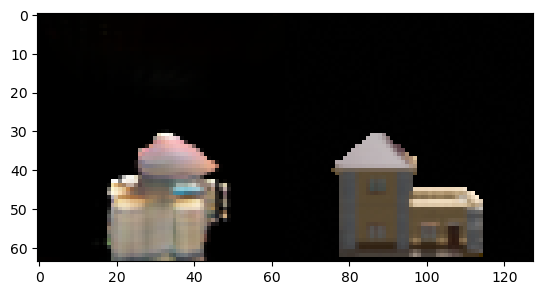

In [16]:
camera_num = 15
ren_imgs = ren_imgs.permute(1, 0, 2, 3)
targ_cam = target_imgs[0].permute(1, 0, 2, 3)[camera_num].unsqueeze(0).squeeze()
targ_cam = (targ_cam - torch.min(targ_cam))
targ_cam /= targ_cam.max()
ren_imag = (ren_imgs[camera_num] - torch.min(ren_imgs[camera_num]))
ren_imag /= torch.max(ren_imgs[camera_num])
plt.imshow(torch.hstack((ren_imag.permute(1, 2, 0), targ_cam.permute(1, 2, 0))), cmap='gray')

In [17]:
# import imageio
# from skimage import img_as_ubyte
from PIL import Image
from torchvision.transforms.functional import to_pil_image

imgs = list()
save_path = Path('./recreated_models')
save_path.mkdir(exist_ok=True)
for camera_num, img in enumerate(ren_imgs):
    targ_cam = target_imgs[0].permute(1, 0, 2, 3)[camera_num].unsqueeze(0).squeeze()
    targ_cam = (targ_cam - torch.min(targ_cam))
    targ_cam /= targ_cam.max()
    ren_imag = (ren_imgs[camera_num] - torch.min(ren_imgs[camera_num]))
    ren_imag /= torch.max(ren_imgs[camera_num])
    imgs.append(to_pil_image(torch.hstack((ren_imag, targ_cam)), mode='RGB'))
    
# imageio.mimsave('model_recreated16.gif', imgs)
imgs[0].save(save_path / "GAN_last_haus41_diff_sil_col_desc_483.gif", save_all=True, append_images=imgs[1:], duration=100, loop=0)